[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Oh-Taegyun/Pytorch_study/blob/main/part8_CNN%20%EC%A0%9C%EC%9E%91%ED%95%98%EA%B8%B0.ipynb)

#### 1. 라이브러리 호출

In [2]:
import torch
import torch.nn as nn
import torch.autograd 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np

#### 2. CPU인지 GPU인지 확인 후 device 설정

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #  torch.cuda.is_available() GPU를 사용가능하면 True, 아니라면 False를 리턴
print("지금 사용하는 device :",device)

지금 사용하는 device : cuda:0


#### 3. 데이터셋 다운받기

- 데이터셋 다운 받는 법

    - train_dataset = torchvision.datasets.FashionMNIST("FashionMNIST를 내려받은 경로", download = True, transform = transform.Compose( [ transform.ToTensor() ] ) )
        - 첫번째 파라미터 : 다운 받을 경로
        - 두번째 파라미터 : 첫 번째 파라미터 즉, 다운 받을 경로에 해당 데이터셋이 있는지 확인한 후 내려받는다
        - 세번째 파라미터 : 이미지를 텐서로 변경하란 
        
> 정보 : https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

In [4]:
train_dataset = torchvision.datasets.FashionMNIST("./FashionMnist",download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./FashionMnist",download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

c:\Users\luili\anaconda3\envs\Pytorch_studing\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)


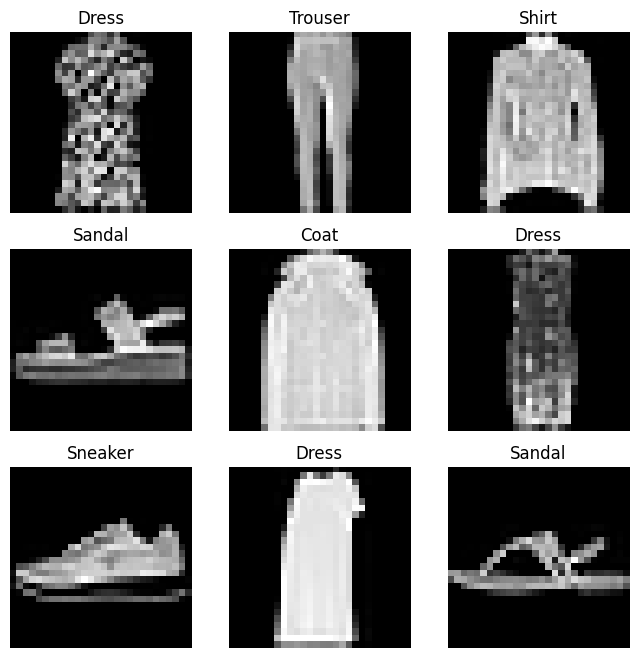

torch.Size([1, 28, 28])


C:\Users\luili\AppData\Local\Temp\ipykernel_15252\3219705334.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure(figsize=(8,8))
cols, rows = 3, 3 # 세로(열) 3, 가로(행) 3

for i in range(1, cols * rows + 1):
    img_xy = np.random.randint(len(train_dataset)) # 데이터셋 번호중 랜덤으로 뽑기
    img = train_dataset[img_xy][0][0,:,:] # 데이터셋은 [이미지 번호][0: 이미지, 1: 레이블][이미지 데이터 : 1x28x28 각각 채널, 가로, 세로이다]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[train_dataset[img_xy][1]]) # 레이블을 타이틀로 설정
    plt.axis('off')
    plt.imshow(img,cmap='gray')

plt.show()

img = train_dataset[img_xy][0]
x = torch.tensor(img)
print(x.size())

In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 600, out_features = 120)
        self.fc3 = nn.Linear(in_features = 120, out_features = 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


입출력 되는 행렬의 계산은 다음과 같다


![입출력행렬](./이미지/image_9.jpg)


합성곱 네트워크를 사용하기 위한 파라미터 설정

In [12]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 손실함수는 교차 엔트로피로 함
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # 아담으로 옵티마이저 설정
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


모델 학습 및 평가

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = torch.tensor(images.reshape(100,1,28,28), requires_grad=True) # 입력값 추적할 수 있게 설정
        labels = torch.tensor(labels,requires_grad=True)

        outputs = model(train)
        loss = criterion(outputs,labels) # 손실함수는 이걸로 구해 
        optimizer.zero_grad() # 이거 안해주면 미분값이 자동적으로 더해져서 이상해짐
        loss.backward() # 이 손실 함수를 구할때까지의 미분 그래프가 형성되었으니 역전파 시켜주면 손실 함수의 미분 값이 나온다
        optimizer.step() # 손실 함수를 줄이는 방향으로 업데이트 해준다
        count += 1

        if not(count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = torch.tensor(images.reshape(100,1,28,28), requires_grad= True)
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device) # (1)번 참고
                predictions_list.append(predictions)

                correct += (predictions == labels).sum() # (2)번 참고
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy)) 

torch.save(model.state_dict(), "./model_state_dict.pt") # 모델 저장

        

### 1. predictions = torch.max(outputs,1)[1].to(device) 에 대하여
---

max는 다음과 같다.
    - https://pytorch.org/docs/stable/generated/torch.max.html#torch.max  
    - torch.max(input, dim, keepdim=False, *, out=None)  
    - 이때 출력값은 튜플로 (max, max_indices)  
 
즉 outputs에서 1차원을 기준으로 최댓값을 구하란 이야기  
outputs는 (100,10)으로 열을 기준으로 최댓값을 구하란 이야기이다

예를 들어
1. a = torch.randn(4, 4)
    - tensor([[-1.2360, -0.2942, -0.1222,  0.8475],  
            [ 1.1949, -1.1127, -2.2379, -0.6702],  
            [ 1.5717, -0.9207,  0.1297, -1.8768],  
            [-0.6172,  1.0036, -0.6060, -0.2432]])  
    #
        
2. torch.max(a, 1) 라고 한다면

    - torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))

    - 이때 1행에서 열을 기준으로 제일 큰것은 0.8475이고 그 인덱스 값은 3번입니다. 라고 출력된다

즉 (100,10)은 1행부터 100행까지 열을 기준으로 큰 값들만 추출해서 나올것이다 

이때 torch.max(outputs,1)[1].to(device) 에서 torch.max(outputs,1)는 튜플로 (큰값, 그 값의 인덱스)인데 인덱스만을 추출해서 device에 올리란 뜻

### 2. 정확도에 관하여
---
다음의 코드를 보자

x,t = get_data() # 그냥 각각의 데이터값과 레이블을 반환  
network = network()  

accuracy_cnt = 0  
for i in range(len(x)):  
　　y = predict(network, x[i]) 　# 대충 예측치 내놓음  
　　p = np.argmax(y) 　# 확률이 가장 높은 인덱스를 추출  
　　if p == t[i]:  　# 만약 레이블값이랑 예측치가 같다면  
　　　　accuracy_cnt += 1  　 # 1을 더함

Accuracy = accuracy_cnt / len(x) 　# 정확도를 구하는 수식

